In [282]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import optuna
from scipy import stats


# Load Data
selected_features_labeled = pd.read_csv("selected_features.csv", sep='\t')

# 1. Data Preprocessing

In [283]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DID040,DIQ220,DIQ190A,DIQ190B,DIQ230,DID260,DIQ280,...,DIQ300D,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,63.0,0.0,1.0,1,1,55,6.9,...,9999,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,63.0,0.0,1.0,1,1,55,6.9,...,9999,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31139.0,1.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,2,10.0,15.0,6.0,0,0.00,0.0,2.0,217
4,31139.0,1.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,2,40.0,30.0,6.0,0,0.00,0.0,2.0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,0.0,0.0,2.0,2,0,0,0.0,...,0,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,0.0,0.0,2.0,2,0,0,0.0,...,0,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,0.0,0.0,2.0,2,0,0,0.0,...,0,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [284]:
## data cleaning

# Check for missing values and zero-value columns
zero_counts = (selected_features_labeled == 0).sum()
print("Total missing values: ", selected_features_labeled.isnull().sum().sum())
print("Missing values per column:\n", selected_features_labeled.isnull().sum())
print("Columns with all zero values:\n", zero_counts)

Total missing values:  0
Missing values per column:
 SEQN        0
BPQ020      0
DIQ010      0
DID040      0
DIQ220      0
DIQ190A     0
DIQ190B     0
DIQ230      0
DID260      0
DIQ280      0
DIQ300S     0
DIQ300D     0
PAQ180      0
PADACTIV    0
PADDURAT    0
SLD010H     0
LBXAPB      0
LBDINSI     0
LBXGH       0
RIAGENDR    0
RIDAGEMN    0
dtype: int64
Columns with all zero values:
 SEQN           0
BPQ020         0
DIQ010         0
DID040      4733
DIQ220      4914
DIQ190A        0
DIQ190B        0
DIQ230      4733
DID260      4765
DIQ280      4785
DIQ300S     4733
DIQ300D     4733
PAQ180         0
PADACTIV       0
PADDURAT       3
SLD010H        0
LBXAPB       349
LBDINSI      372
LBXGH        329
RIAGENDR       0
RIDAGEMN      32
dtype: int64


In [285]:
# Drop columns with around 9,000 missing values (NaN values get converted to 0)
selected_features_labeled = selected_features_labeled.drop(columns=['DID040', 'DIQ220', 'DIQ230', 'DID260', 'DIQ280', 'DIQ300S', 'DIQ300D'], errors='ignore')

In [286]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31139.0,1.0,2.0,1.0,1,2,10.0,15.0,6.0,0,0.00,0.0,2.0,217
4,31139.0,1.0,2.0,1.0,1,2,40.0,30.0,6.0,0,0.00,0.0,2.0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [287]:
# Drop rows where certain columns contain zeros (NaN values get converted to 0)
cols_to_check = ['LBXAPB', 'LBDINSI', 'LBXGH', 'PADDURAT', 'RIDAGEMN']
selected_features_labeled = selected_features_labeled[(selected_features_labeled[cols_to_check] != 0).all(axis=1)]

In [288]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
17,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
18,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [289]:
# Save cleaned data
selected_features_labeled.to_csv("selected_features_final.csv", sep='\t', index=False)

In [290]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
17,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
18,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


## 1a. Further Preprocessing
### Dropped values similar to missing values ("Don't Know")

In [291]:
sfl_final = pd.read_csv("selected_features_final.csv", sep='\t')

In [292]:
sfl_final

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
4,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4532,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4533,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4534,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [293]:
# columns: BPQ020, DIQ010, DIQ190A, DIQ190B, PAQ180, PADACTIV, SLD010H
# values: 9, 99, 71 (other for PADACTIV)

# List of columns and values to filter
filters = {
    'DIQ190A': '9',
    'DIQ190B': '9',
    'PAQ180': '9',
    'PADACTIV': '71',
    'SLD010H': '99',
}

# Apply filters sequentially, checking for empty DataFrames and column existence
for column, value in filters.items():
    if column in sfl_final.columns: 
        # Ensure the column data type is string
        sfl_final[column] = sfl_final[column].astype(str).str.strip()
        # Filter out rows where the column matches the value
        sfl_final = sfl_final[sfl_final[column] != str(value)]
    else:
        print(f"Column '{column}' not found. Skipping.")

print(sfl_final.columns)
sfl_final.to_csv("selected_features_final.csv", index=False)


Index(['SEQN', 'BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV',
       'PADDURAT', 'SLD010H', 'LBXAPB', 'LBDINSI', 'LBXGH', 'RIAGENDR',
       'RIDAGEMN'],
      dtype='object')


In [294]:
sfl_final

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
4,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4532,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4533,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4534,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


# 2. Data Preparation for Analysis
## Criteria Filtering

In [275]:
## preDM filter

# Reload cleaned dataset
combined_selected_features = pd.read_csv("selected_features_final.csv")

# Define PreDM condition
preDM_criteria = (combined_selected_features['LBDINSI'] >= 100) | (combined_selected_features['LBXAPB'] >= 110) | (combined_selected_features['LBXGH'] >= 5.5)

# Add 'PreDM' label
combined_selected_features['PreDM'] = preDM_criteria.astype(int)

# Drop features used for labeling
combined_selected_features = combined_selected_features.drop(columns=['LBDINSI', 'LBXAPB', 'LBXGH'], errors='ignore')

# Save final labeled dataset
combined_selected_features.to_csv("selected_features_labeled_final.csv", sep='\t', index=False)


In [151]:
# prepare data for analysis, train/test
# Load labeled dataset
labeled_selected_features = pd.read_csv("selected_features_labeled_final.csv", sep='\t')

# Define features and target
X = labeled_selected_features[['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'PADDURAT', 'SLD010H', 'RIAGENDR', 'RIDAGEMN']]
y = labeled_selected_features["PreDM"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 3. Model Training and Evaluation

In [276]:
## train/evaluate model

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}\n", classification_report(y_test, y_pred_dt))

# Logistic Regression
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log:.2f}\n", classification_report(y_test, y_pred_log_reg))

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train, verbose=False)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}\n", classification_report(y_test, y_pred_xgb))


Decision Tree Accuracy: 0.83
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       427
           1       0.83      0.84      0.84       481

    accuracy                           0.83       908
   macro avg       0.83      0.83      0.83       908
weighted avg       0.83      0.83      0.83       908

Logistic Regression Accuracy: 0.67
               precision    recall  f1-score   support

           0       0.63      0.75      0.68       427
           1       0.73      0.61      0.66       481

    accuracy                           0.67       908
   macro avg       0.68      0.68      0.67       908
weighted avg       0.68      0.67      0.67       908

XGBoost Accuracy: 0.81
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       427
           1       0.82      0.81      0.82       481

    accuracy                           0.81       908
   macro avg       0.81      0.81     

# 4. Cross Validation of Models

In [295]:
## cross-validation of models

kf = KFold(n_splits=10, shuffle=True)
    #random_state = 42

# Decision Tree CV
dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"Decision Tree Mean CV Accuracy: {dt_scores.mean():.2f}")

# Logistic Regression CV
lr_scores = cross_val_score(LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"Logistic Regression Mean CV Accuracy: {lr_scores.mean():.2f}")

# XGBoost CV
xgb_scores = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42,alpha=0.5), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")
#print(sns.boxplot(xgb_scores))


Decision Tree Mean CV Accuracy: 0.80
Logistic Regression Mean CV Accuracy: 0.62
XGBoost Mean CV Accuracy: 0.78


# 5. Regularization and T-test to Optimize Code
## Visualization (Box Plot) of XGBoost Scores
### using reg_alpha and reg_lambda

C:\Users\Kannan\AppData\Local\Temp\ipykernel_39016\1598565753.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(["With Alpha", "Without Alpha"])


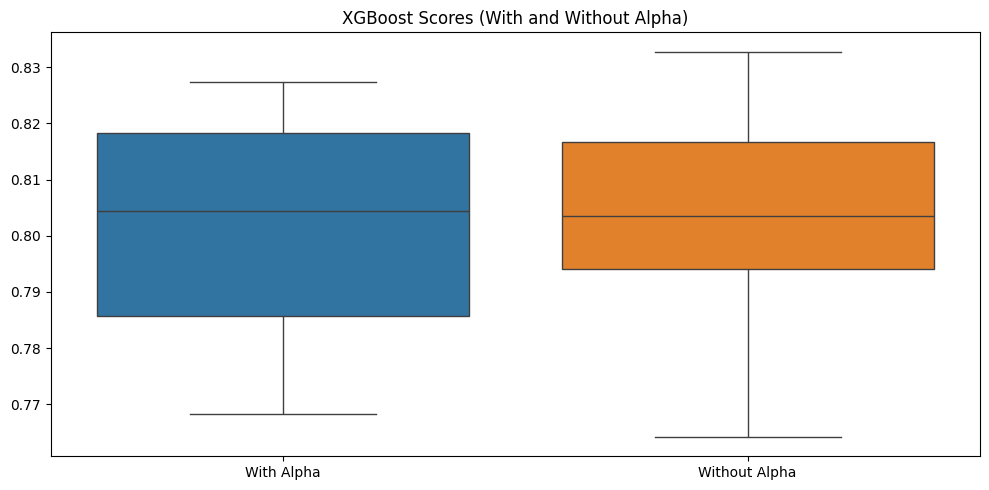

' print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")\nprint(sns.boxplot(xgb_scores_w_alpha))\nprint(sns.boxplot(xgb_scores_wo_alpha)) '

In [301]:
## box plot of xgboost scores with and without alpha

xgb_scores_w_alpha = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42,reg_lambda= 0.04039211783792193, reg_alpha=0.10189315999689169), X_train_scaled, y_train, cv=kf, scoring='f1')
xgb_scores_wo_alpha = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42), X_train_scaled, y_train, cv=kf, scoring='accuracy')

box_plots = [xgb_scores_w_alpha, xgb_scores_wo_alpha]

fig, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(data=box_plots, ax=axes)
axes.set_title("XGBoost Scores (With and Without Alpha)")
axes.set_xticklabels(["With Alpha", "Without Alpha"])

""" sns.boxplot(x=xgb_scores_wo_alpha, ax=axes[1])
axes[1].set_title("XGBoost Scores (Without Alpha)") """

plt.tight_layout()

plt.savefig("final_visualizations/xgb_scores_alpha.png", dpi=300, bbox_inches="tight")
#plt.savefig("final_visualizations/xgb_scores_wo_alpha.png", dpi=300, bbox_inches="tight")

plt.show()

""" print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")
print(sns.boxplot(xgb_scores_w_alpha))
print(sns.boxplot(xgb_scores_wo_alpha)) """

## Hyperparameter tuning (reg_lambda and reg_alpha)
### with a custom range of values

In [297]:
# lowest variance estimation using reg_lambda and reg_alpha
# calculation of values

# parameter ranges
reg_lambda_values = [0.1, 0.2, 0.3, 0.4, 0.5]
reg_alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]

results = {}

for reg_lambda in reg_lambda_values:
    for reg_alpha in reg_alpha_values:
        model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, reg_lambda=reg_lambda, reg_alpha=reg_alpha)
        scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='f1')
        variance = np.var(scores)
        
        results[(reg_lambda, reg_alpha)] = variance

# Find the pair with the lowest variance
best_params = min(results, key=results.get)
best_lambda, best_alpha = best_params
lowest_variance = results[best_params]

# Print best values
print(f"Best reg_lambda: {best_lambda}")
print(f"Best reg_alpha: {best_alpha}")
print(f"Lowest variance: {lowest_variance:.6f}")




Best reg_lambda: 0.3
Best reg_alpha: 0.2
Lowest variance: 0.000143


## Hyperparameter tuning (t-test and chi-square test)

### identify continous and categorical features

In [312]:

categorical_cols = ['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'RIAGENDR']
continuous_cols = ['PADDURAT', 'SLD010H', 'RIDAGEMN']

#X.loc[:, continuous_cols_to_convert] = X[continuous_cols_to_convert].astype('category')

#categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

## chi-square test

# Identify continuous columns
#continuous_vars = X.select_dtypes(include=['float64', 'int64']).columns  
print("Continuous Columns:", continuous_cols)



Categorical Columns: ['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'RIAGENDR']
Continuous Columns: ['PADDURAT', 'SLD010H', 'RIDAGEMN']


### t-test for continous variables

In [315]:
# T-test for variable significance (univariate t-tests)

p_values = {}
for col in continuous_cols:
    group1 = X[y == 0][col]  # Values where PreDM is 0
    group2 = X[y == 1][col]  # Values where PreDM is 1
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False) # Welch's t-test
    p_values[col] = p_val
""" print("\nP-values for each variable (univariate t-tests):")
for col, p_val in p_values.items():
    print(f"{col}: {p_val:.4f}") """

## save p-values to csv
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'P-value'])
p_values_df.to_csv("selected_features_final_p-values_t_test.csv", index=False)

print(p_values_df)

print("\nP-values for each variable (univariate t-tests) saved to variable_p_values.csv")

   Variable        P-value
0  PADDURAT   5.276048e-01
1   SLD010H   2.570208e-01
2  RIDAGEMN  7.287179e-104

P-values for each variable (univariate t-tests) saved to variable_p_values.csv


### chi-square test for categorical variables

In [316]:
# Dictionary to store p-values from Chi-Square tests
chi2_p_values = {}

# Iterate through each categorical column identified
print("\nPerforming Chi-Square tests for association with target variable 'y'...")
for col in categorical_cols:
    # Create a contingency table (cross-tabulation) between the feature and the target
    contingency_table = pd.crosstab(X[col], y)

    # Perform the Chi-Square test of independence
    # This test checks if the observed frequencies in the table deviate significantly
    # from the frequencies that would be expected if there were no association
    # between the feature (col) and the target (y).
    try:
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

        # Store the p-value
        chi2_p_values[col] = p_val
        # print(f"Chi-Square test for {col}: p-value = {p_val:.4f}") # Optional: print individual results

    except ValueError as e:
        # Handle cases where chi2_contingency might fail (e.g., all values in a row/column are 0)
        print(f"Could not perform Chi-Square test for {col}: {e}")
        chi2_p_values[col] = None # Or np.nan

print("\nP-values for each categorical variable (Chi-Square tests):")
for col, p_val in chi2_p_values.items():
    if p_val is not None:
        print(f"{col}: {p_val:.4f}")
    else:
        print(f"{col}: Test failed")

# Save Chi-Square p-values to a CSV file
chi2_p_values_df = pd.DataFrame(list(chi2_p_values.items()), columns=['Variable', 'P-value_Chi2'])
chi2_p_values_df.to_csv("selected_features_final_p-values_chi2_test.csv", index=False)

print("\nChi-Square P-values saved to categorical_features_p_values_chi2.csv")


Performing Chi-Square tests for association with target variable 'y'...

P-values for each categorical variable (Chi-Square tests):
BPQ020: 0.0000
DIQ010: 0.0000
DIQ190A: 0.0000
DIQ190B: 0.0000
PAQ180: 0.0000
PADACTIV: 0.0000
RIAGENDR: 0.2017

Chi-Square P-values saved to categorical_features_p_values_chi2.csv


## Hyperparameter tuning (Optuna)

In [300]:
## optuna hyperparameter optimization

# Define the objective function
def objective(trial):
    # Suggest values for reg_lambda and reg_alpha
    reg_lambda = trial.suggest_loguniform("reg_lambda", 0.01, 100)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 0.01, 100)

    # Define the model with the suggested hyperparameters
    model = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha
    )

    # Perform cross-validation and compute the mean F1 score
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)  # Optuna will maximize this value

# Create and run the optimization study
study = optuna.create_study(direction="maximize")  # We want to maximize the F1 score
study.optimize(objective, n_trials=50)  # Run 50 trials

# Get the best hyperparameters
best_params = study.best_params
best_score = study.best_value

print(f"Best reg_lambda: {best_params['reg_lambda']}")
print(f"Best reg_alpha: {best_params['reg_alpha']}")
print(f"Best mean F1 score: {best_score:.4f}")


[I 2025-04-01 17:46:13,373] A new study created in memory with name: no-name-0d2863da-437b-49c4-95bd-92d4e0453bd9
C:\Users\Kannan\AppData\Local\Temp\ipykernel_39016\3111329490.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 0.01, 100)
C:\Users\Kannan\AppData\Local\Temp\ipykernel_39016\3111329490.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 0.01, 100)
[I 2025-04-01 17:46:14,654] Trial 0 finished with value: 0.757791202904589 and parameters: {'reg_lambda': 36.47302367038632, 'reg_alpha': 0.6459554553225191}. Best is trial 0 with value: 0.757791202904589.
C:\Use

Best reg_lambda: 0.04039211783792193
Best reg_alpha: 0.10189315999689169
Best mean F1 score: 0.8136


# 6. Confusion Matrix Analysis and Identifying Correct/Incorrect Values

<Figure size 1000x600 with 0 Axes>

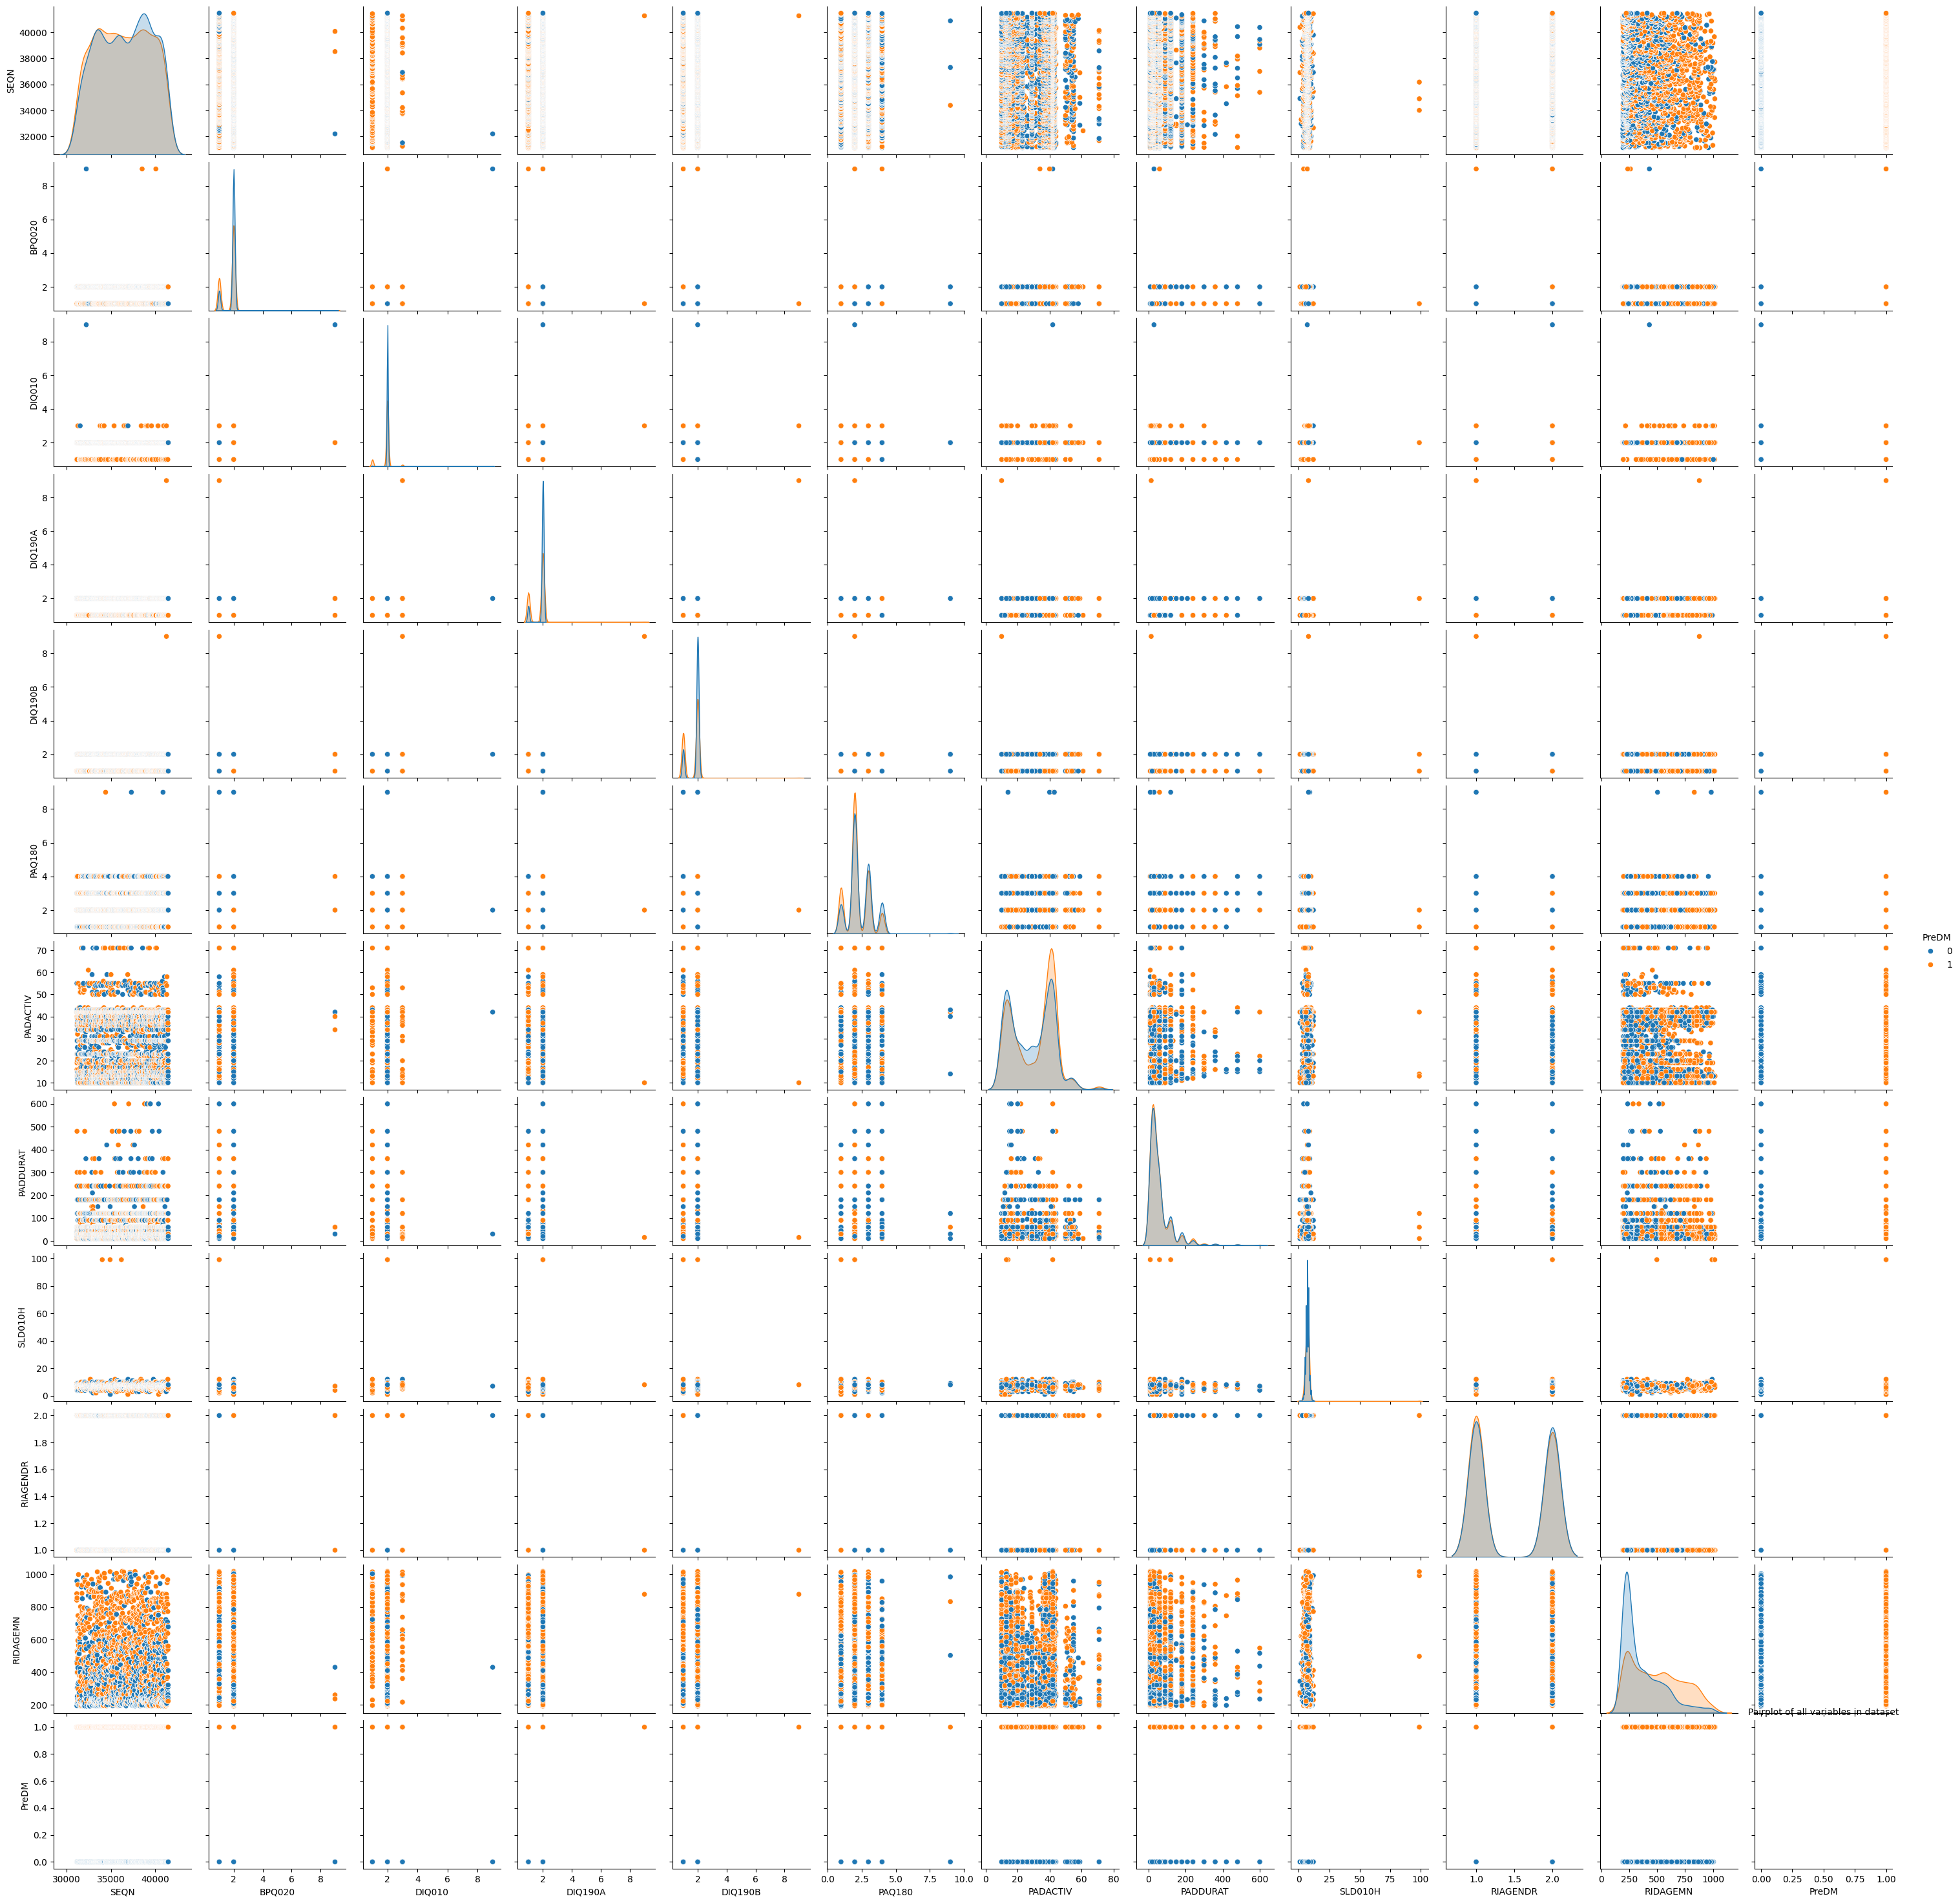

In [318]:
## pairplot before confusion matrix of entire dataset
entire_dataset = [col for col in labeled_selected_features.columns 
                       if labeled_selected_features[col].dtype in ['float64', 'int64']]
    
plt.figure(figsize=(10,6))

sns.pairplot(labeled_selected_features, vars=entire_dataset, hue='PreDM', diag_kind='kde')
plt.title("Pairplot of all variables in dataset", fontsize=10)
print("test line")
plt.savefig("final_visualizations/pairplot_before_division_cm.png")
    
plt.show()


In [319]:
## confusion matrix using XGBoost model

# Function to plot confusion matrix
def plot_confusion_matrix(cm, fold_num):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {fold_num}")
    #plt.savefig('final_visualizations/confusion_matrix.png')
    #plt.show()

# XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, alpha=0.5)

fold_cm = []
total_samples = 0
all_predictions = np.zeros(len(y))  # Start with zeros for all predictions

for fold_num, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)

    all_predictions[test_index] = y_pred_cv

    #print(y_pred_cv)

    cm = confusion_matrix(y_test_cv, y_pred_cv)
    fold_cm.append(cm)

    print(f"Confusion Matrix for Fold {fold_num}: \n{cm}\n")

     # Plot confusion matrix after each fold
    #plot_confusion_matrix(cm, fold_num)

# Compare predictions to actual values and label them as correct (1) or incorrect (0)
correct_predictions = (all_predictions == y).astype(int)

labeled_selected_features["Prediction_Correct"] = correct_predictions
    
labeled_selected_features.to_csv("selected_features_labeled_final_with_predictions.csv", sep='\t', index=False)

# Count of correct predictions (where Prediction_Correct == 1)
correct_count = labeled_selected_features["Prediction_Correct"].sum()

# Count of incorrect predictions (where Prediction_Correct == 0)
incorrect_count = len(labeled_selected_features) - correct_count

# Print the results
print(f"Correct Predictions: {correct_count}")
print(f"Incorrect Predictions: {incorrect_count}")

print(correct_predictions)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:PADDURAT: category, SLD010H: category, RIAGENDR: category, RIDAGEMN: category

In [ ]:
# comparison of correct and wrong values
correct = labeled_selected_features[labeled_selected_features['Prediction_Correct']==1]
wrong = labeled_selected_features[labeled_selected_features['Prediction_Correct']==0]

# 7. Analysis of Correct/Incorrect Values

In [ ]:
# statistics of correct and wrong values
correct_desc = correct.describe()
wrong_desc = wrong.describe()
display(correct_desc)
display(wrong_desc)

correct_desc.to_csv("selected_features_final_correct_desc_stats.csv")
wrong_desc.to_csv("selected_features_final_wrong_desc_stats.csv")

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM,Prediction_Correct
count,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.0
mean,36445.114921,1.790249,1.955800,1.778194,1.716314,2.340745,29.518082,58.047415,6.995446,1.475221,434.158586,0.487544,1.0
std,2948.715908,0.407185,0.257631,0.433197,0.467192,0.874580,13.231127,63.415422,2.934846,0.499453,220.741517,0.499912,0.0
min,31132.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000,192.000000,0.000000,1.0
25%,33853.000000,2.000000,2.000000,2.000000,1.000000,2.000000,15.000000,20.000000,6.000000,1.000000,230.000000,0.000000,1.0
50%,36504.000000,2.000000,2.000000,2.000000,2.000000,2.000000,33.000000,30.000000,7.000000,1.000000,376.000000,0.000000,1.0
75%,38963.000000,2.000000,2.000000,2.000000,2.000000,3.000000,42.000000,60.000000,8.000000,2.000000,593.000000,1.000000,1.0
max,41465.000000,2.000000,3.000000,9.000000,9.000000,9.000000,71.000000,600.000000,99.000000,2.000000,1019.000000,1.000000,1.0


,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM,Prediction_Correct
count,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.0
mean,36522.666252,1.865504,2.006227,1.905355,1.830635,2.225405,29.237858,60.513076,7.070984,1.496887,416.207970,0.559153,0.0
std,3012.470532,0.570989,0.266521,0.292907,0.375308,0.822230,13.758315,72.195051,1.378927,0.500302,212.236095,0.496798,0.0
min,31153.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000,192.000000,0.000000,0.0
25%,33936.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000,20.000000,6.000000,1.000000,234.000000,0.000000,0.0
50%,36517.000000,2.000000,2.000000,2.000000,2.000000,2.000000,33.000000,30.000000,7.000000,1.000000,349.000000,1.000000,0.0
75%,39080.000000,2.000000,2.000000,2.000000,2.000000,3.000000,42.000000,60.000000,8.000000,2.000000,547.500000,1.000000,0.0
max,41472.000000,9.000000,9.000000,2.000000,2.000000,9.000000,71.000000,600.000000,12.000000,2.000000,1004.000000,1.000000,0.0


In [ ]:
# correct prediction versus wrong prediction

# correct and wrong values 

correct.to_csv("selected_features_final_with_predictions_correctValues.csv", sep='\t')
wrong.to_csv("selected_features_final_with_predictions_wrongValues.csv", sep='\t')

In [320]:
# Transpose the correct and wrong values to make it suitable for pairplot (each column represents a feature)

correct_transposed = correct.T
wrong_transposed = wrong.T

print(correct_transposed)
print(wrong_transposed)

                       0        1        2        3        4        5     \
SEQN                31132.0  31132.0  31134.0  31148.0  31150.0  31150.0   
BPQ020                  1.0      1.0      1.0      2.0      2.0      2.0   
DIQ010                  1.0      1.0      2.0      2.0      2.0      2.0   
DIQ190A                 1.0      1.0      1.0      2.0      2.0      2.0   
DIQ190B                 1.0      1.0      1.0      2.0      2.0      2.0   
PAQ180                  2.0      2.0      3.0      2.0      4.0      4.0   
PADACTIV               42.0     19.0     42.0     23.0     43.0     55.0   
PADDURAT               40.0    240.0     30.0     60.0     60.0     30.0   
SLD010H                 7.0      7.0      7.0      7.0      8.0      8.0   
RIAGENDR                1.0      1.0      1.0      2.0      1.0      1.0   
RIDAGEMN              842.0    842.0    882.0    194.0    959.0    959.0   
PreDM                   1.0      1.0      1.0      0.0      0.0      0.0   
Prediction_C

In [ ]:
## pairplot of correct and wrong values

sns.pairplot(correct, hue='PreDM', diag_kind='kde')
plt.suptitle("Pairplot of Correct Values ", y=1.02)
#sns.pairplot(labeled_selected_features, vars=renamed_vars, hue='PreDM', diag_kind='kde')
plt.savefig("final_visualizations/pairplot_correct_values.png")

sns.pairplot(wrong,  hue='PreDM', diag_kind='kde')
plt.suptitle("Pairplot of Wrong Values ", y=1.02)
plt.savefig("final_visualizations/pairplot_wrong_values.png")

#plt.show()

# 8. Visualizations of Dataset
## SHAP values

In [321]:
# SHAP values visualization using xgboost - entire dataset

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

print("Shape of X:", X.shape)
print("Shape of shap_values:", shap_values.shape)

shap.summary_plot(shap_values, X, show=False)

plt.suptitle("SHAP Plot of Entire Dataset ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_entireDataset.png", bbox_inches='tight', dpi=300)
plt.show()


NotFittedError: need to call fit or load_model beforehand

Shape of Correct Values (features only): (3709, 10)
Shape of shap_values_correct: (3709, 10)


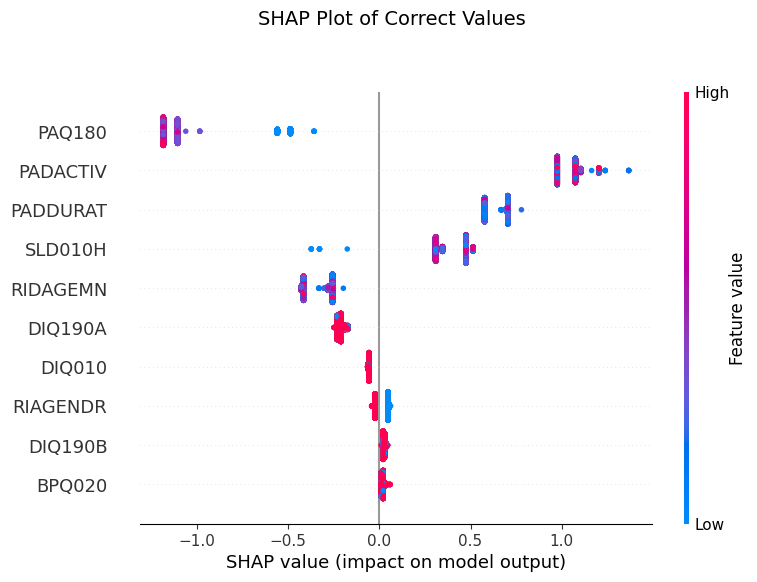

In [91]:
# SHAP values visualization using xgboost - correct values
# training data - X_train
feature_names = X_train.columns.tolist()

#feature_names = xgb_model.feature_names
features_only_correct = correct[feature_names]

explainer = shap.TreeExplainer(xgb_model)
shap_values_correct = explainer.shap_values(features_only_correct)

print("Shape of Correct Values (features only):", features_only_correct.shape)
print("Shape of shap_values_correct:", shap_values_correct.shape)

shap.summary_plot(shap_values_correct, features_only_correct, show=False)

plt.suptitle("SHAP Plot of Correct Values ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_correctValues.png", bbox_inches='tight', dpi=300)
plt.show()


Shape of Wrong Values (features only): (827, 10)
Shape of shap_values_wrong: (827, 10)


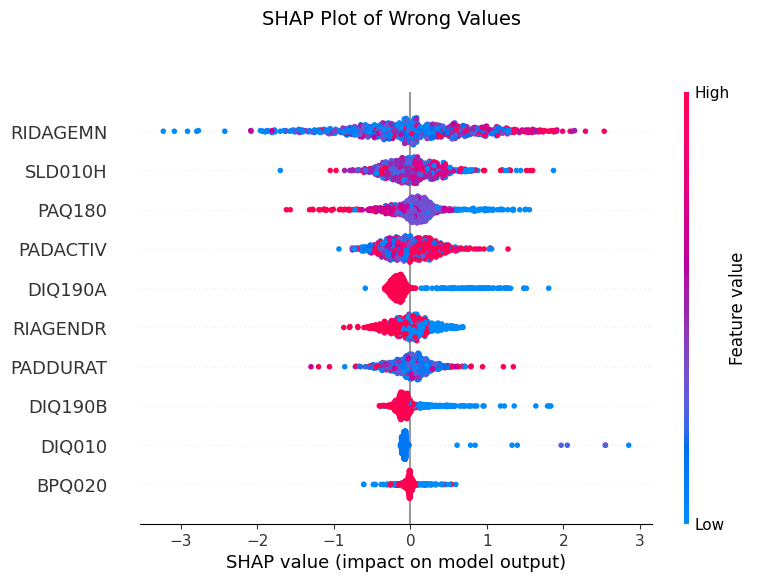

In [39]:
# SHAP values visualization using xgboost - wrong values
# training data - X_train
feature_names = X_train.columns.tolist()

#feature_names = xgb_model.feature_names
features_only_wrong = wrong[feature_names]

explainer = shap.TreeExplainer(xgb_model)
shap_values_wrong = explainer.shap_values(features_only_wrong)

print("Shape of Wrong Values (features only):", features_only_wrong.shape)
print("Shape of shap_values_wrong:", shap_values_wrong.shape)

shap.summary_plot(shap_values_wrong, features_only_wrong, show=False)

plt.suptitle("SHAP Plot of Wrong Values ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_wrongValues.png", bbox_inches='tight', dpi=300)
plt.show()
